# Phase 2, Verb Frames

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments import VerbFrame
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/semantics/project_code/lingo/heads/tf/c']
TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex vs language
                pdp freq_lex gloss domain ls
                heads prep_obj mother rela
                typ sp st
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='phase2_composite_space', version='c')

This is Text-Fabric 4.0.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

116 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 4.0.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

## Load the Experiment and Space

In [2]:
vfe = VerbFrame(tf_api=tf_api)
print(f'verb frame experiment ready with dim {vfe.data.shape}')
vfs = SemSpace(vfe, info=True)

verb frame experiment ready with dim (955, 341)
  0.00s Applying association measure(s)...
   |     0.00s Applying PPMI...
   |     0.09s Finished PPMI...
  0.09s Building pairwise matrices...
   |     0.00s Building pairwise distances...
   |     0.07s Building pairwise similarities...
  7.80s space is ready!


## Visualize and Explore Space

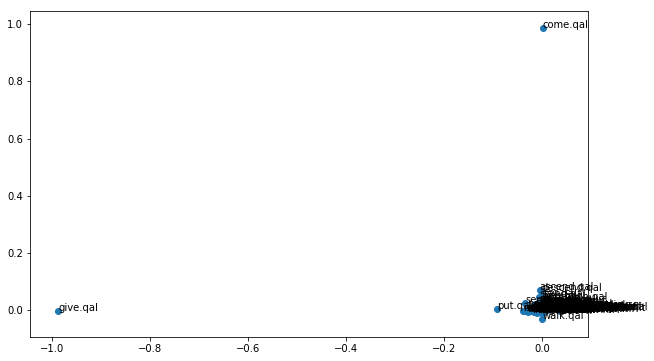

In [18]:
vfs.pmi_plot.show() # NB, this is currently using sparse PCA

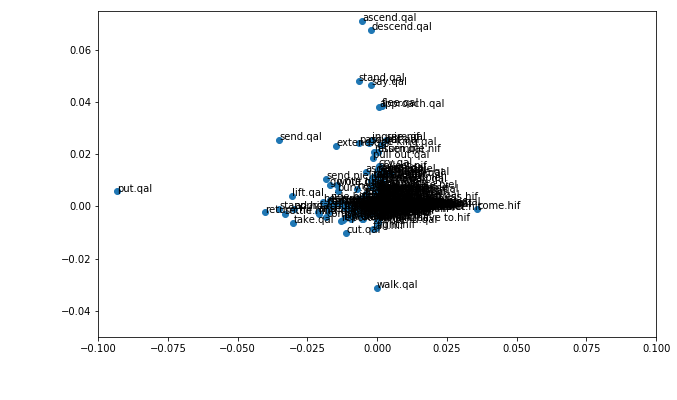

In [6]:
vfs.pmi_plot.show(axis=[-0.1, 0.1, -0.05, 0.075])

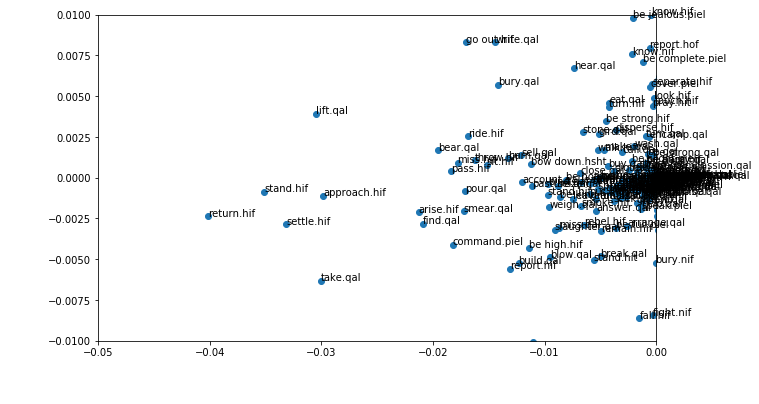

In [13]:
vfs.pmi_plot.show(axis=[-0.05, 0.0, -0.01, 0.01])

In [10]:
#vfs.pmi_plot.show(axis=[-2, 15, -10, 20]) # uncomment and run when normal PCA is used

In [11]:
#vfs.pmi_plot.show(axis=[-2, 3, -5, 8]) # uncomment and run when normal PCA is used

In [15]:
freq_sorted = vfs.raw.sum().sort_values(ascending=False).head(200)

In [17]:
for lex in freq_sorted.index[:10]:
    key = f'{lex} ({vfe.target2gloss[lex]})'
    print(vfs.distance_pmi_pca[key].sort_values().head(10))
    print()

>MR[.qal (say)         0.000000
R>H[.nif (see)         0.101253
QHL[.nif (assemble)    0.125290
CB<[.nif (swear)       0.131566
>SP[.nif (gather)      0.132097
CM<[.qal (hear)        0.133034
RJB[.qal (contend)     0.133816
CWB[.qal (return)      0.133836
MWT[.qal (die)         0.134591
Z<Q[.qal (cry)         0.136449
Name: >MR[.qal (say), dtype: float64

HJH[.qal (be)        0.000000
>MR[.qal (say)       0.919909
MWT[.qal (die)       0.926033
R>H[.nif (see)       0.933968
BKH[.qal (weep)      0.937367
QWM[.qal (arise)     0.938489
CM<[.qal (hear)      0.940553
NGD[.hif (report)    0.947316
NPL[.qal (fall)      0.948353
CWB[.qal (return)    0.949326
Name: HJH[.qal (be), dtype: float64

BW>[.qal (come)        0.000000
JRD[.qal (descend)     0.919822
<MD[.qal (stand)       0.943362
NWS[.qal (flee)        0.948210
QRB[.qal (approach)    0.950214
>MR[.qal (say)         0.951221
DRC[.qal (inquire)     0.962485
<BR[.qal (pass)        0.963432
NVH[.qal (extend)      0.963547
R>H[.nif (see)   

### Clustering

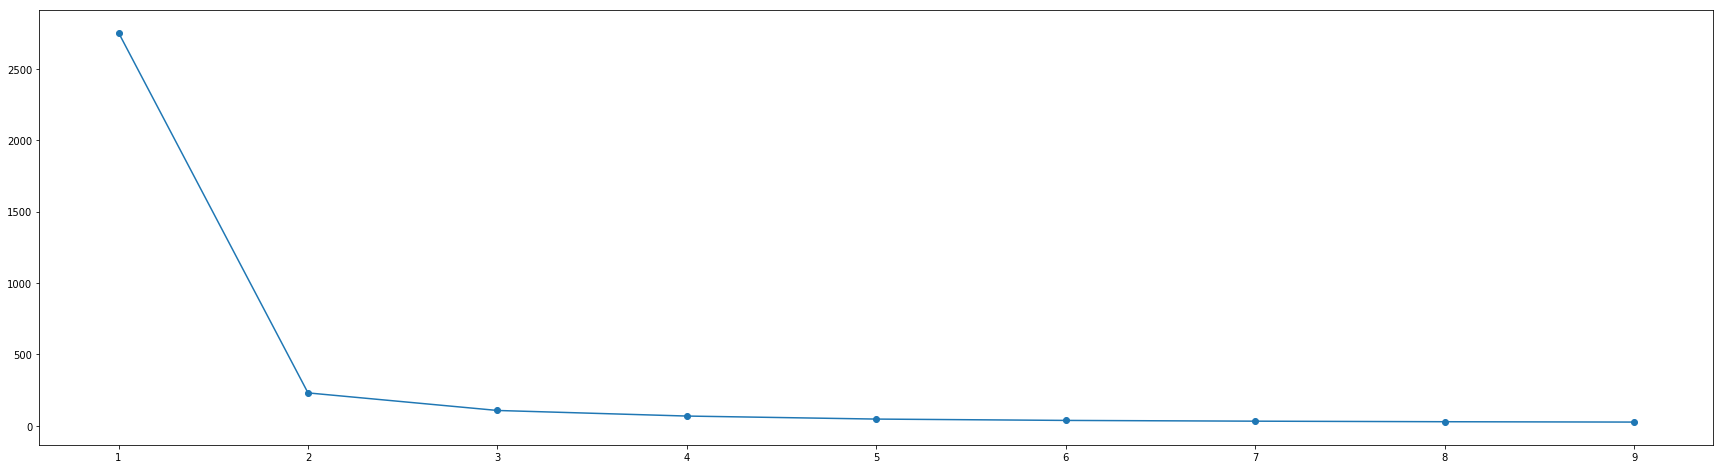

In [20]:
test = vfs.pairwise_pmi_pca

k_to_squared = []
k_range = range(1, 10, 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.nan_to_num(test, 0))
    k_to_squared.append((k, kmeans.inertia_))
    
x = [ks[0] for ks in sorted(k_to_squared)]
y = [ks[1] for ks in sorted(k_to_squared)]
   
plt.figure(figsize=(30, 8))
ax = plt.axes()
ax.set_xticks(tuple(k_range))
plt.plot(x, y)
plt.scatter(x, y)

In [24]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(np.nan_to_num(test, 0))

cglossed = pd.DataFrame(kmeans.labels_, 
                        index=[f'{F.lex.v(vfe.target2lex[w])}.{F.vs.v(vfe.target2node[w])} -- {vfe.target2gloss[w]}' for w in vfs.raw.columns], 
                        columns=['cluster']).fillna(0)

clustmin = pd.DataFrame(kmeans.labels_, 
                        index=vfs.raw.columns, 
                        columns=['cluster']).fillna(0)

gloss_to_lex = dict(zip(cglossed.index, clustmin.index))

In [25]:
clustmin.cluster.value_counts()

0    313
2     18
1     10
Name: cluster, dtype: int64

In [26]:
sorted_cluster_names = cglossed.cluster.unique()
sorted_cluster_names.sort()

for cname in sorted_cluster_names:
    
    cluster = cglossed[cglossed.cluster == cname]
    lexs = [lex.split()[0] for lex in cluster.index]
    
    
    print(f'CLUSTER {cname}')
    print(cluster.shape)
    print()
    print('TOP ARGUMENTS:')
    print(vfs.raw[lexs].sum(axis=1).sort_values(ascending=False).head(10))
    print()
    print(cluster.head(15))
    print()
    print('-'*40)

CLUSTER 0
(313, 1)

TOP ARGUMENTS:
Pred|Objc.subs           1983.0
Pred                     1843.0
Pred|Cmpl.B               494.0
Pred|Cmpl.L               397.0
Pred|Cmpl.<L              242.0
Pred|Cmpl.MN              237.0
Pred|Cmpl.>L              198.0
Pred|Cmpl.L|Objc.subs     171.0
Pred|                     116.0
Pred|Cmpl.B|Objc.subs      92.0
dtype: float64

                              cluster
<BD[.qal -- work, serve             0
<BR[.hif -- pass                    0
<BR[.qal -- pass                    0
<FH[.nif -- make                    0
<LH[.nif -- ascend                  0
<MD[.hif -- stand                   0
<NH=[.piel -- be lowly              0
<NH[.qal -- answer                  0
<RK[.qal -- arrange                 0
<TR[.nif -- entreat                 0
<WD[.hif -- warn, to witness        0
<ZB[.qal -- leave                   0
<ZR[.qal -- help                    0
>BD[.piel -- perish                 0
>BH[.qal -- want                    0

--------------------

## Non-Subject Elements

In [21]:
bases=('Objc',)

vfe2 = VerbFrame(tf_api=tf_api, bases=bases)
print(f'verb frame experiment ready with dim {vfe2.data.shape}')
vf2 = SemSpace(vfe2, info=True)

verb frame experiment ready with dim (9, 341)
  0.00s Applying association measure(s)...
   |     0.00s Applying PPMI...
   |     0.01s Finished PPMI...
  0.01s Building pairwise matrices...
   |     0.00s Building pairwise distances...
   |     0.01s Building pairwise similarities...
  0.16s space is ready!


In [22]:
vf2.raw.sum(axis=1).sort_values(ascending=False).head(10)

Pred                        14799.0
Pred|Objc.subs               4804.0
Pred|                         428.0
Pred|Objc.subs|Objc.subs      201.0
Pred||Objc.subs                42.0
Pred|Objc.conj                 16.0
Pred|Objc.prde                 12.0
Pred|Objc.prin                  5.0
Pred|Objc.conj|Objc.subs        1.0
dtype: float64

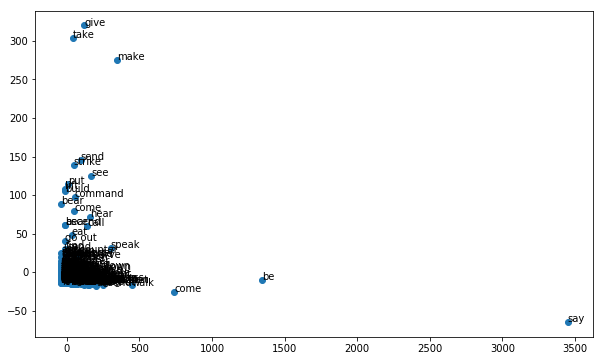

In [23]:
vf2.raw_plot.show()

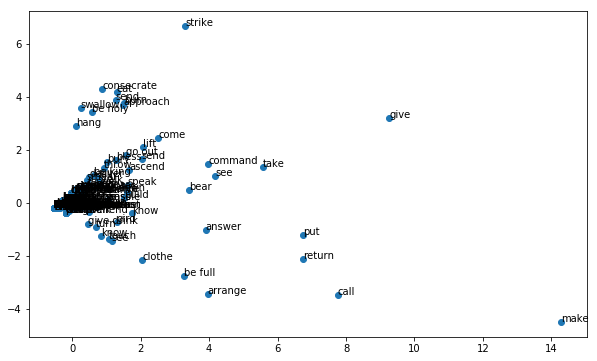

In [24]:
vf2.pmi_plot.show()

### Clustering

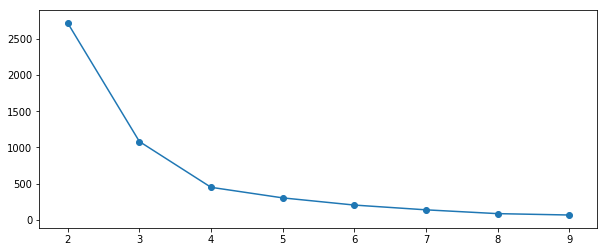

In [27]:
test = vf2.pairwise_jaccard

k_to_squared = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.nan_to_num(test, 0))
    k_to_squared.append((k, kmeans.inertia_))
    
x = [ks[0] for ks in sorted(k_to_squared)]
y = [ks[1] for ks in sorted(k_to_squared)]
   
plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.set_xticks(tuple(k_range))
plt.plot(x, y)
plt.scatter(x, y)

In [30]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.nan_to_num(test, 0))

cglossed = pd.DataFrame(kmeans.labels_, 
                        index=[f'{F.lex.v(vfe2.target2lex[w])}.{F.vs.v(vfe2.target2node[w])} -- {vfe2.target2gloss[w]}' for w in vf2.raw.columns], 
                        columns=['cluster']).fillna(0)

clustmin = pd.DataFrame(kmeans.labels_, 
                        index=vf2.raw.columns, 
                        columns=['cluster']).fillna(0)

gloss_to_lex = dict(zip(cglossed.index, clustmin.index))

In [31]:
sorted_cluster_names = cglossed.cluster.unique()
sorted_cluster_names.sort()

for cname in sorted_cluster_names:
    
    cluster = cglossed[cglossed.cluster == cname]
    lexs = [lex.split()[0] for lex in cluster.index]
    
    
    print(f'CLUSTER {cname}')
    print(cluster.shape)
    print()
    print('TOP ARGUMENTS:')
    print(vf2.raw[lexs].sum(axis=1).sort_values(ascending=False).head(10))
    print()
    print(cluster.head(15))
    print()
    print('-'*40)

CLUSTER 0
(114, 1)

TOP ARGUMENTS:
Pred                        5915.0
Pred|Objc.subs               964.0
Pred||Objc.subs                0.0
Pred|Objc.subs|Objc.subs       0.0
Pred|Objc.prin                 0.0
Pred|Objc.prde                 0.0
Pred|Objc.conj|Objc.subs       0.0
Pred|Objc.conj                 0.0
Pred|                          0.0
dtype: float64

                              cluster
<MD[.qal -- stand                   0
<NH=[.piel -- be lowly              0
<RK[.qal -- arrange                 0
<WD[.hif -- warn, to witness        0
<ZR[.qal -- help                    0
>BD[.piel -- perish                 0
>BH[.qal -- want                    0
>MN[.hif -- be firm                 0
>MR[.qal -- say                     0
>WR[.hif -- be light                0
BQ<[.qal -- split                   0
BQC[.piel -- seek                   0
BXR[.qal -- examine                 0
BZH[.qal -- despise                 0
BZZ[.qal -- spoil                   0

-------------------------